### 1. Import dependencies

In [14]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [15]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [16]:
import torchfunc
import flowDataset
from torch.utils.data.sampler import SubsetRandomSampler


In [17]:
torch.__version__
torchfunc.cuda.reset()
torch.cuda.empty_cache()

### 2. Create PyTorch data generators

In [18]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}


In [19]:
dataset = flowDataset.flowDataset(data_transforms['train'])

In [20]:
batch_size = 50
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [21]:
dataloaders = {
    'train': train_loader,
    'validation': test_loader
}

### 3. Create the network

In [22]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device = torch.device("cuda:0")

In [23]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 7)).to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

### 4. Train the model

In [25]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects.float() / len(dataloaders[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss.item(), epoch_acc.item()))
    return model

In [26]:
model_trained = train_model(model, criterion, optimizer, num_epochs=50)

Epoch 1/50
----------
train loss: 67.2427, acc: 20.5455
validation loss: 52.8789, acc: 25.3333
Epoch 2/50
----------
train loss: 46.2851, acc: 29.6364
validation loss: 52.3963, acc: 21.0000
Epoch 3/50
----------
train loss: 39.6073, acc: 32.5455
validation loss: 50.4256, acc: 18.0000
Epoch 4/50
----------
train loss: 37.5836, acc: 32.3636
validation loss: 45.7901, acc: 21.0000
Epoch 5/50
----------
train loss: 37.2072, acc: 31.4545
validation loss: 37.7234, acc: 27.3333
Epoch 6/50
----------
train loss: 34.2204, acc: 33.7273
validation loss: 33.5855, acc: 29.6667
Epoch 7/50
----------
train loss: 32.8150, acc: 34.5455
validation loss: 31.3752, acc: 33.0000
Epoch 8/50
----------
train loss: 29.7926, acc: 35.0909
validation loss: 33.3047, acc: 30.6667
Epoch 9/50
----------
train loss: 29.9684, acc: 35.1818
validation loss: 33.1543, acc: 31.0000
Epoch 10/50
----------
train loss: 29.3298, acc: 34.7273
validation loss: 34.8153, acc: 30.6667
Epoch 11/50
----------
train loss: 30.2854, acc: 

### 5. Save and load the model

In [27]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [28]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 7)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

<All keys matched successfully>

### 6. Make predictions on sample test images

In [29]:
validation_img_paths = ["D:/Flow Videos/dataset/frame_64.jpg",
                        "D:/Flow Videos/dataset/frame_536.jpg",
                        "D:/Flow Videos/dataset/frame_450.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [30]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [31]:
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

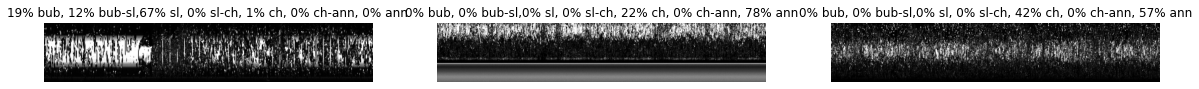

In [32]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% bub, {:.0f}% bub-sl,{:.0f}% sl, {:.0f}% sl-ch, {:.0f}% ch, {:.0f}% ch-ann, {:.0f}% ann".format(
    100*pred_probs[i,0], 100*pred_probs[i,1],100*pred_probs[i,2],100*pred_probs[i,3],100*pred_probs[i,4],100*pred_probs[i,5],100*pred_probs[i,6]))
    ax.imshow(img)